# $\textit{Predicción lineal}$
$\textit{By Agustín Luís Gullino - Gonzalo Ezequiel Linares}$

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as sp
import scipy.io as io
import helper as hp
import importlib
from numpy.fft import fft, rfft
from numpy.fft import fftshift, fftfreq, rfftfreq
from IPython.display import Audio
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# $\textit{1)}$

Se tomaron grabaciones de voz de ambos sonidos como fué solicitado. Para asegurar el uso de predicción estacionaria, se realizó un test de estacionaridad para verificar esto, y los resultados observados permiten concluir que la señal es estacionaria con un alto grado de confianza. Posterior a esto, se restó la media de la señal como precaución para evitar que se vea afectada por los filtros. También se realizó un análisis de las señales, graficandolas en el tiempo, observando una estimacion de su PSD, y tambien una estimación de su autocorrelación.

In [5]:
fss, signal, path = hp.getRecordedSignals()

In [21]:
hp.play(signal=signal["a"], fs=fss["a"])

In [ ]:
from arch.unitroot import ADF
from arch.unitroot import PhillipsPerron

''' 
Para el test, se tiene en cuenta que las hipotesis son:

H0: La serie contiene raiz unitaria.
H1: La serie es estacionaria.

Si el p-valor esta por encima del critico, la hipotesis nula no puede ser rechazada, indicando que 
la serie no es estacionaria.
'''

norm1 = signal["a"]
norm2 = signal["sh"]
max_lags_test=len(signal["a"])//10

adf = ADF(norm1, max_lags=max_lags_test)
print(adf.summary().as_text())
print("Dado que P-value = 0, podemos concluir que la señal de aaa es estacionaria.")
print('\n//////////////////////////////////////\n')

adf = ADF(norm2, max_lags=max_lags_test)
print(adf.summary().as_text())
print("Dado que P-value = 0, podemos concluir que la señal de shh estacionaria.")

pp = PhillipsPerron(norm1)
print(pp.summary().as_text())
print("Dado que P-value = 0, podemos concluir que la señal de aaa estacionaria.")
print('\n//////////////////////////////////////\n')

pp = PhillipsPerron(norm2)
print(pp.summary().as_text())
print("Dado que P-value = 0, podemos concluir que la señal de shh estacionaria.")

In [22]:
signal["a"] -= np.mean(signal["a"])
signal["sh"] -= np.mean(signal["sh"])

Text(0, 0.5, 'y(n)')

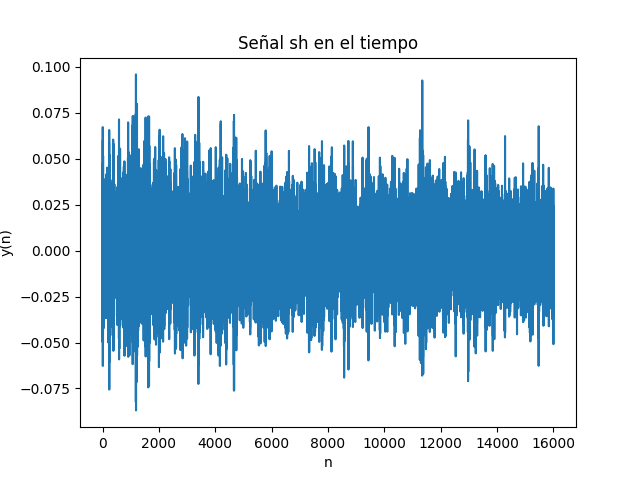

In [12]:
plt.figure()
plt.title("Señal sh en el tiempo")
plt.plot(signal["sh"])
plt.xlabel("n")
plt.ylabel("y(n)")

Text(0, 0.5, 'y(n)')

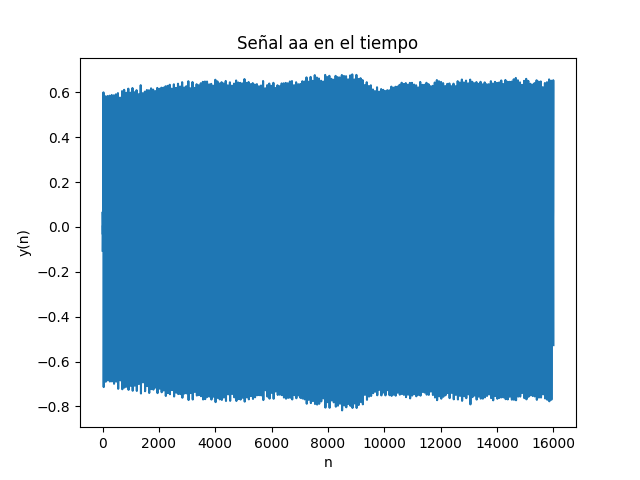

In [13]:
plt.figure()
plt.title("Señal aa en el tiempo")
plt.plot(signal["a"])
plt.xlabel("n")
plt.ylabel("y(n)")

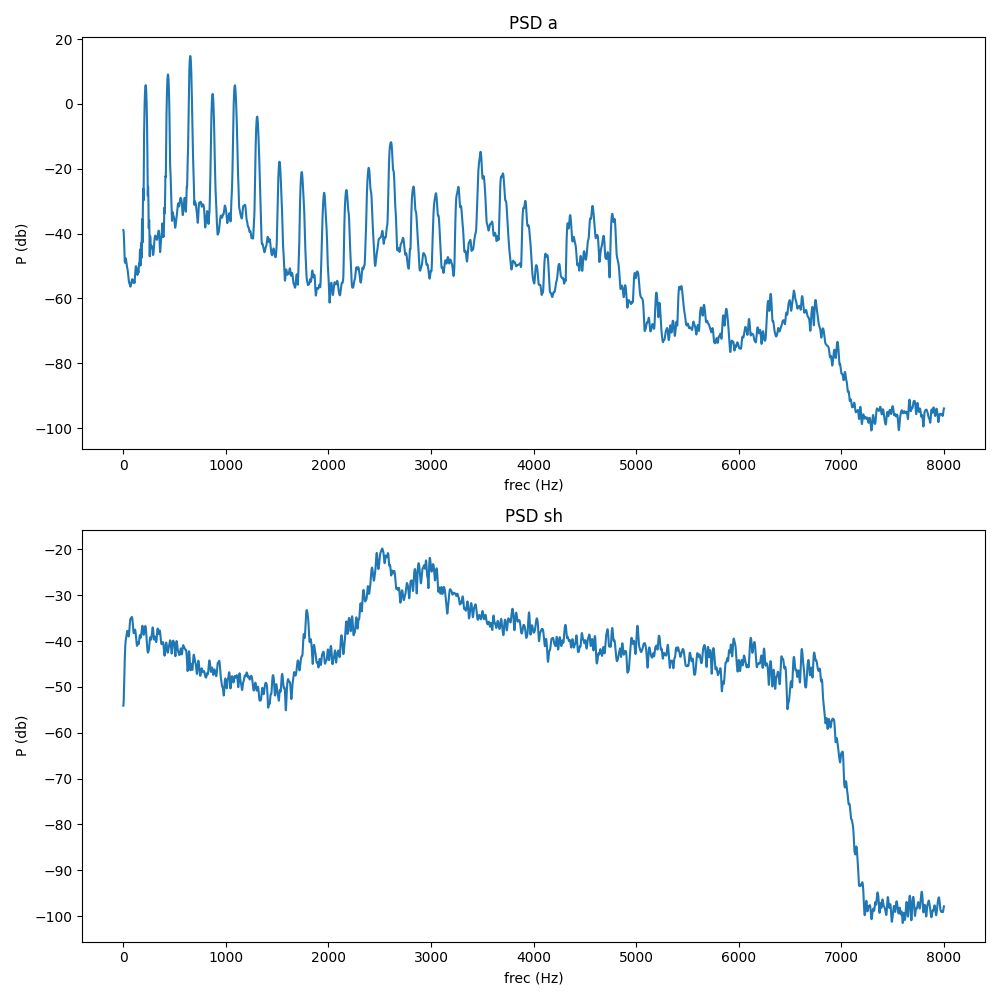

In [15]:
plt.figure(tight_layout=True, figsize=(10, 10))
plt.subplot(211)
freq, psd, L = hp.periodogram_averaging(signal["a"], fss['a'], len(signal["a"])//10, 8, lambda N: sp.get_window('hann', N))
A = 10*np.log10(psd+1e-18)
plt.title("PSD a")
plt.xlabel("frec (Hz)")
plt.ylabel("P (db)")
plt.plot(freq, A)

plt.subplot(212)
freq, psd, L = hp.periodogram_averaging(signal["sh"], fss['sh'], len(signal["sh"])//10, 8, lambda N: sp.get_window('hann', N))
A = 10*np.log10(psd+1e-18)
plt.title("PSD sh")
plt.xlabel("frec (Hz)")
plt.ylabel("P (db)")
plt.plot(freq, A)

Text(0, 0.5, 'rxx')

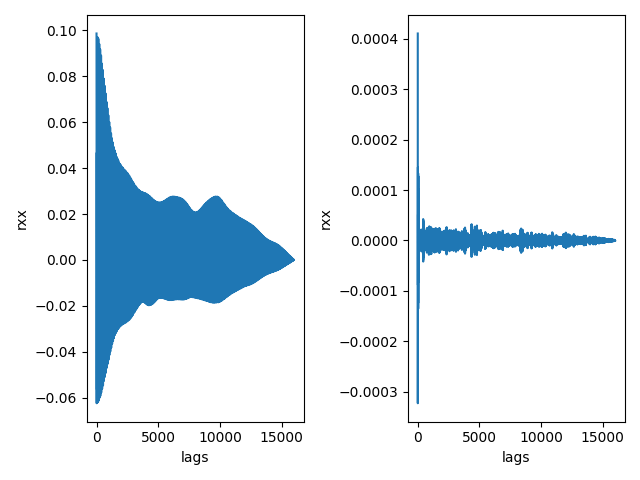

In [23]:
lags = sp.correlation_lags(len(signal["a"]), len(signal["a"]))
N = len(signal["a"])
rxa = sp.correlate(signal["a"], signal["a"])/N
rxsh = sp.correlate(signal["sh"], signal["sh"])/N

plt.figure(tight_layout=True)
plt.subplot(121)
plt.plot(lags[lags >= 0], rxa[lags >= 0])
plt.xlabel("lags")
plt.ylabel("rxx")
plt.subplot(122)
plt.plot(lags[lags >= 0], rxsh[lags >= 0])
plt.xlabel("lags")
plt.ylabel("rxx")


# $\textit{2)}$

Calculando y graficando Jo(M), se pueden observar 2 codos para /a/ y 1 codo para /sh/.
En el caso de /a/, se observó que el error rápidamente desciende hasta encontrar el primer codo en aproximadamente M=15. Y luego, se estabiliza para nuevamente decrecer. Este primer codo indica que los primeros coeficientes aportan un gran valor a la predicción de /a/, pero si se observa la señal error y la señal /a/, se puede ver que existen grandes picos separados por aproximadamente 70 muestras, que aportan energía en la señal error y no son modelados por nuestro predictor. Por estos picos, es que nuestro error encuentra un nuevo codo en approx M=70. Al agregar el retardo 70, el filtro ya puede capturar ese detalle y agregarlo en el modelo del predictor, capturando la energía que esto implica y disminuyendo así, el error.

En el caso de /sh/, esta señal no presenta una correlación fuerte para lags lejanos, por lo que existe un único codo y ocurre en M=20 aproximadamente. Si se observa con detalle el gráfico del error para distintos M, se puede observar que para M=16 en adelante no se nota un cambio importante en la señal de error, apoyando lo concluído anteriormente. 

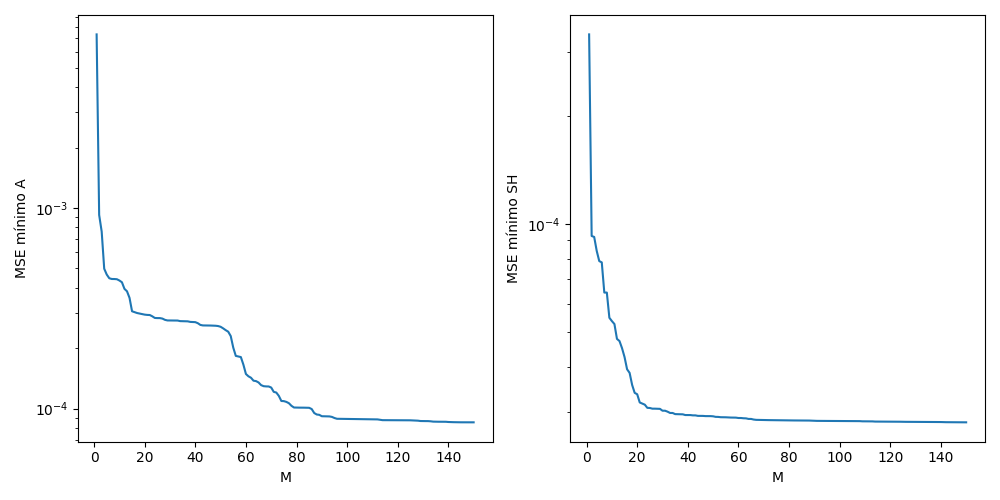

In [24]:
Ms = np.linspace(1, 150, 150, dtype=int)
wo_a = np.zeros((len(Ms)), dtype=np.ndarray)
wo_sh = np.zeros((len(Ms)), dtype=np.ndarray)
a_a = np.zeros((len(Ms)), dtype=np.ndarray)
a_sh = np.zeros((len(Ms)), dtype=np.ndarray)
jos_a = np.zeros(len(Ms))
jos_sh = np.zeros(len(Ms))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), tight_layout=True)

for i, M in enumerate(Ms):
    wo, jo, NMSE = hp.get_optimal_params(signal["a"], M)
    jos_a[i] = jo
    a_a[i] = np.insert(-wo, 0, 1) 
    wo_a[i] = wo

    wo, jo, NMSE = hp.get_optimal_params(signal["sh"], M)
    wo_sh[i] = wo
    jos_sh[i] = jo
    a_sh[i] = np.insert(-wo, 0, 1) 

axs[0].set_xlabel('M')
axs[0].set_ylabel('MSE mínimo A')
axs[0].plot(Ms, jos_a)
axs[0].set_yscale('log')

axs[1].set_xlabel('M')
axs[1].set_ylabel('MSE mínimo SH')
axs[1].plot(Ms, jos_sh)
axs[1].set_yscale('log')


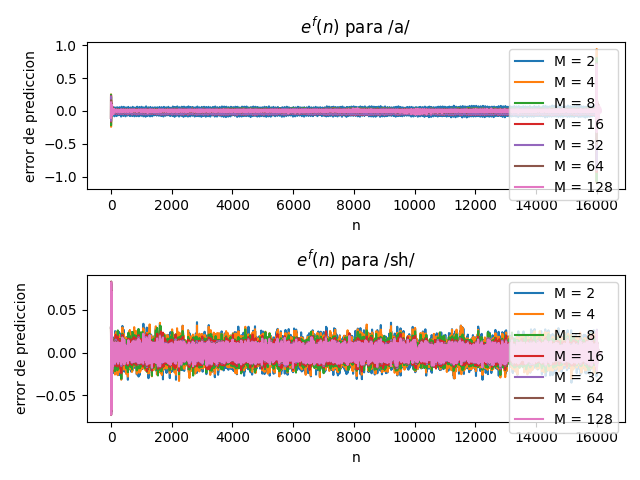

In [25]:

plt.figure(tight_layout=True)
plt.subplot(211)

for i in np.logspace(start=1, stop=7, num=7, base=2, endpoint=True, dtype=int):
    N = len(a_a[i])
    e_foa = np.convolve(a_a[i], signal["a"])
    plt.plot(e_foa, label=f'M = {i}')

plt.title("$e^f(n)$ para /a/")
plt.xlabel("n")
plt.ylabel("error de prediccion")
plt.legend()

plt.subplot(212)
for i in np.logspace(start=1, stop=7, num=7, base=2, endpoint=True, dtype=int):
    N = len(a_sh[i])
    e_fosh = np.convolve(a_sh[i], signal["sh"])
    plt.plot(e_fosh, label=f'M = {i}')

plt.title("$e^f(n)$ para /sh/")
plt.xlabel("n")
plt.ylabel("error de prediccion")
plt.legend()


# $\textit{3)}$

Si se observa la respuesta del filtro de error de ambas señales con el espectro de potencia estimado en el punto 1, se puede ver que para ordenes crecientes, las respuestas de los filtros convergen a la transformación inversa de la señal de entrada, en otras palabras, convergen al filtro "whitening". Si se observa la estimación de la PSD del error de salida, se puede ver que para el caso de /a/, mientras más se incrementa el orden del filtro, más se reducen los picos de armónicos, y más se "aplana" el espectro. Es importante observar que la energía de los picos disminuyó muy poco para orden M=64 comparado con lo anterior, lo que muestra nuevamente que se requieren ordenes mayores para mejorar. Observar que los picos se encuentran en aprox. 216 Hz, y 16000Hz / 216Hz = 74, lo que nuevamente indica el motivo del segundo codo.

En el caso de /sh/ para M=16, ya se puede ver un espectro más plano en comparación a ordenes menores, y en los ordenes crecientes se ven mejoras poco significativas, lo cúal indica nuevamanete porque existe un codo cerca de M=20.

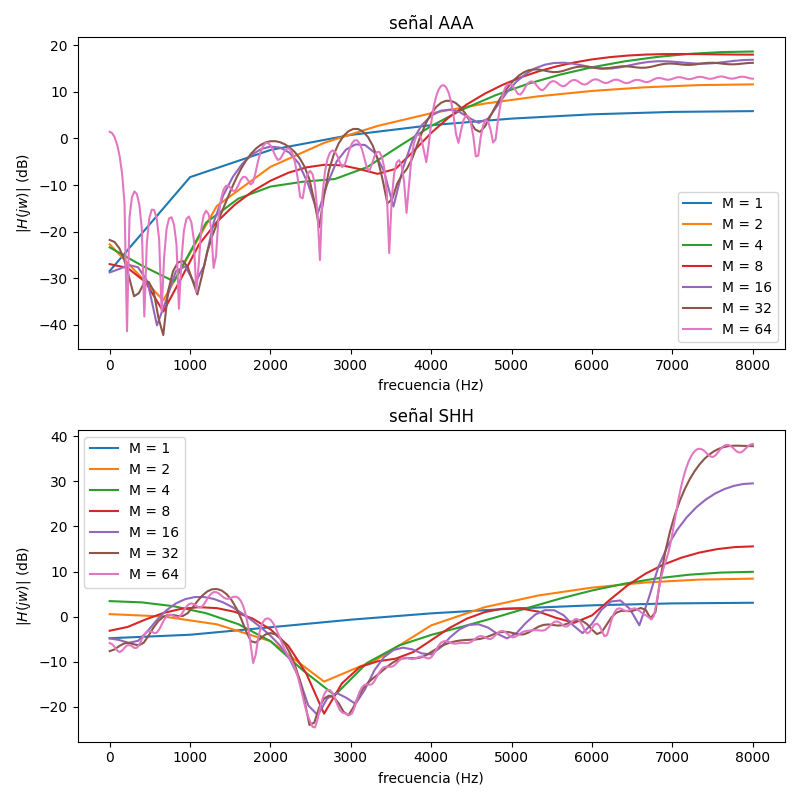

In [28]:
plt.figure(tight_layout=True, figsize=(8, 8))
plt.subplot(211)
for i in np.logspace(0, 6, 7, endpoint=True, base=2, dtype=int):
    N = len(a_a[i-1])
    freq = rfftfreq(N*8, 1/fss["a"])
    Hejw = rfft(a_a[i-1], N*8)
    A = 20*np.log10((np.abs(Hejw)+1e-18))
    plt.plot(freq, A, label=f'M = {i}')

plt.title("señal AAA")
plt.xlabel("frecuencia (Hz)")
plt.ylabel("$|H(jw)|$ (dB)")
plt.legend()

plt.subplot(212)
for i in np.logspace(0, 6, 7, endpoint=True, base=2, dtype=int):
    N = len(a_sh[i-1])
    freq = rfftfreq(N*8, 1/fss["sh"])
    Hejw = rfft(a_sh[i-1], N*8)
    A = 20*np.log10((np.abs(Hejw)+1e-18))
    plt.plot(freq, A, label=f'M = {i}')

plt.title("señal SHH")
plt.xlabel("frecuencia (Hz)")
plt.ylabel("$|H(jw)|$ (dB)")
plt.legend()

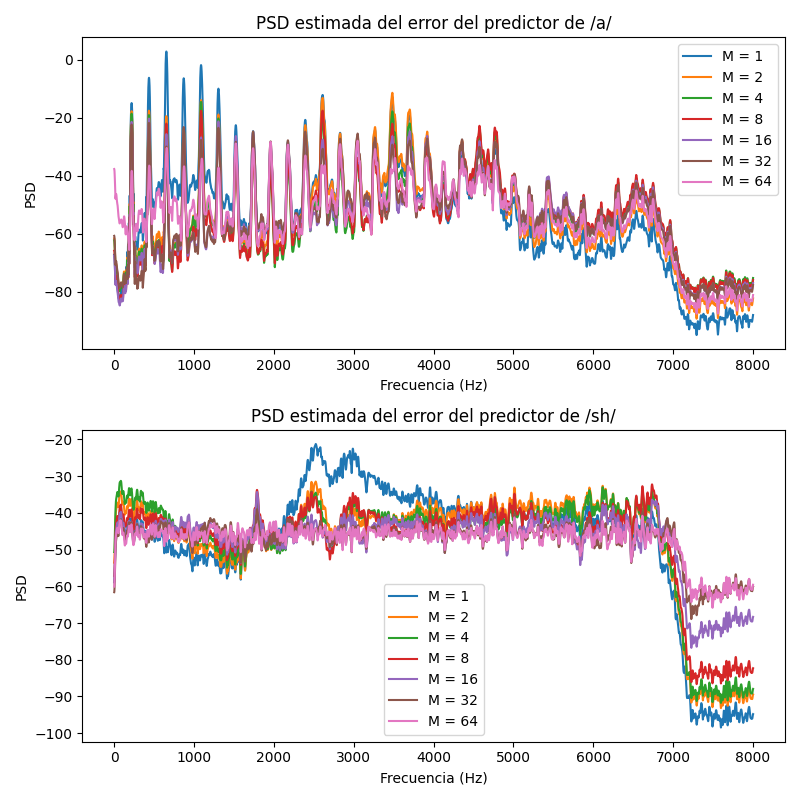

In [36]:
plt.figure(tight_layout=True, figsize=(8, 8))
plt.subplot(211)

for i in np.logspace(0, 6, 7, endpoint=True, base=2, dtype=int):
    err_fa = sp.lfilter(a_a[i-1], [1], signal['a']) 
    freq, psd, L = hp.periodogram_averaging(err_fa, fss['a'], len(err_fa)//10, 8, lambda N: sp.get_window('hann', N))
    A = 10*np.log10(psd+1e-18)
    plt.plot(freq, A, label=f'M = {i}')

plt.title("PSD estimada del error del predictor de /a/")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("PSD")
plt.legend()

plt.subplot(212)
for i in np.logspace(0, 6, 7, endpoint=True, base=2, dtype=int):
    err_fsh = sp.lfilter(a_sh[i-1], [1], signal['sh'])
    freq, psd, L = hp.periodogram_averaging(err_fsh, fss['sh'], len(err_fsh)//10, 8, lambda N: sp.get_window('hann', N))
    A = 10*np.log10(psd+1e-18)
    plt.plot(freq, A, label=f'M = {i}')
    

plt.title("PSD estimada del error del predictor de /sh/")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("PSD")
plt.legend()

# $\textit{4)}$

En el caso de la /a/, como se vió que el filtro para un orden del primer codo no logra una señal error blanca, se decidió sintetizar un modelo de error AR. Este modelo AR se tomo de un orden p = 90, que se encuentra luego del 2do codo esperando que con esto se pueda lograr modelar esas correlaciones y obtener un buen resultado de síntesis. Esto se pudo comprobar empíricamente si se escucha a la señal original y se la compara con la sintetizada con el error modelado con AR. En comparación con un error Gaussiano, el AR genera un /a/ sintetizado mucho más similar al original, en comparación con el gaussiano que genera un sonido mucho más cercano a ruido que a /a/.

Para el caso de /sh/, como se observó que el espectro de salida era plano (por lo menos hasta 7000Hz que corresponde con el ancho de banda de la señal de entrada), se utilizó un error modelado por un ruido gaussiano, que dió resultados favorables si se comparan ambas señales de forma perceptual.

In [37]:
Ma = 16
Msh = 20

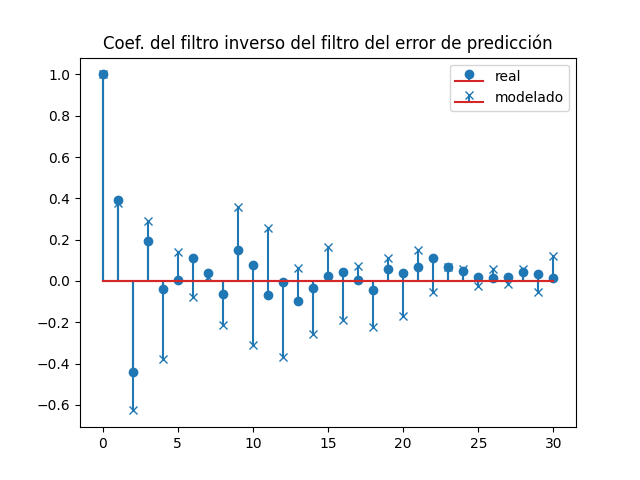

In [40]:
plt.figure()

# Generamos una estimacion del modelo AR que ajusta al error
model = AutoReg(err_fa, 90)
results = model.fit()
coeffs = results.params
#
# Plot the prediction vs test data
#
err_sint = np.random.normal(0, 0.01, fss["a"]*1)
err_sint2 = sp.lfilter([1], np.concatenate((np.array([1]), -coeffs[1:])), err_sint)

plt.title("Coef. del filtro inverso del filtro del error de predicción")
plt.stem(pacf(err_fa, 30), label='real')
plt.stem(pacf(err_sint2, 30), label='modelado', markerfmt='x')
plt.legend()

In [41]:
out = sp.lfilter([1], a_a[Ma], err_sint)
out2 = sp.lfilter([1], a_a[Ma], err_sint2)

display('Original:' , Audio(data=signal['a'], rate=fss["a"]))
display('Error gaussiano:' , Audio(data=out, rate=fss["a"]))
display('Error AR:' ,Audio(data=out2, rate=fss["a"]))


'Original:'

'Error gaussiano:'

'Error AR:'

In [42]:
err_sint = np.random.normal(0, 0.01, fss["sh"]*2)
out = sp.lfilter([1], a_sh[Msh], err_sint)

display('Original:' , Audio(data=signal['sh'], rate=fss["sh"]))
display('Error gaussiano:' , Audio(data=out, rate=fss["sh"]))

'Original:'

'Error gaussiano:'

# $\textit{5)}$

Lo que se esperaba de esta prueba era poder sintetizar nuevamente un fragmento de voz a través del modelado de predictores óptimos para fragmentos de 50ms (800 muestras). Si se asume que estos fragmentos son localmente estacionarios, el filtro del error de predición óptimo converge a un filtro blanqueador. Al aplicar la inversa de este filtro a un tren de deltas de 160 Hz (5 deltas por bloque)

In [43]:
fsfrase, frase = io.wavfile.read("recFrase1.wav")
L = 800
overlap = 400
hann_window = sp.get_window('hann', L)
splitted_frase = np.array([frase[i*overlap : i*overlap + L]*hann_window for i in range(0, len(frase)//overlap-1)])
print(splitted_frase.shape)

(351, 800)


C:\Users\Gonzalo\AppData\Local\Temp\ipykernel_14736\779089221.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fsfrase, frase = io.wavfile.read("recFrase1.wav")


In [44]:
M = 12
fimpulse = 160
slen = len(splitted_frase)
wos = np.zeros((slen, M))
coefs = np.zeros((slen, M+1))
jos = np.zeros(slen)

for i in range(slen):
    #Realizamos la prediccion forward
    wo, jo, NMSE = hp.get_optimal_params(splitted_frase[i], M)
    jos[i] = jo
    coefs[i] = np.insert(-wo, 0, 1) 
    wos[i] = wo

impulsos = sp.unit_impulse(len(frase), [np.arange(0, len(frase) + 1, fsfrase//fimpulse)])
splitted_impulse = np.array([impulsos[i*overlap : i*overlap + L] for i in range(0, len(impulsos)//overlap-1)])
print(splitted_impulse.shape)

(351, 800)


c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\signal\_waveforms.py:671: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[idx] = 1


In [45]:
results = np.zeros(overlap*(slen+1))

for i, coeffs in enumerate(coefs):
    results[i*overlap : i*overlap + L] += sp.lfilter([1], coeffs, splitted_impulse[i])*hann_window

display(Audio(data=results, rate=fsfrase))
display(Audio(data=frase, rate=fsfrase))
io.wavfile.write(data=results, rate=fsfrase, filename='frase_reversed.wav')